<a href="https://colab.research.google.com/github/elangbijak4/Causality-Base-PCA/blob/main/Demo2_Quantum_Causality_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Toy QCM (scalar contraction) ===
          X0        X1        X2        X3        X4        X5
X0  0.610463 -0.036901 -0.292930  0.890275  0.835339 -0.136359
X1 -0.036901  2.995517  0.256103  0.700109 -0.507176 -0.124304
X2 -0.292930  0.256103  1.108866 -0.386009 -0.297115 -0.067667
X3  0.890275  0.700109 -0.386009  2.163257  0.719872 -0.805326
X4  0.835339 -0.507176 -0.297115  0.719872  1.567852  0.505497
X5 -0.136359 -0.124304 -0.067667 -0.805326  0.505497  1.657106

Top eigenvalues: [3.659068 3.211145 1.983347 0.958008 0.291493]



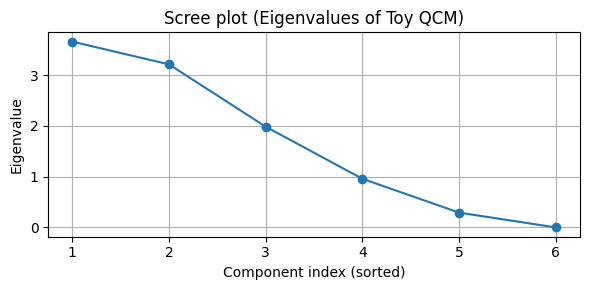

=== Feature coordinates in 2D QC-PCA surrogate ===
         PC1       PC2
X0  0.450742  0.608933
X1  1.211478 -1.081174
X2 -0.131650 -0.478140
X3  1.270489  0.626218
X4  0.206842  1.023122
X5 -0.560323  0.062154



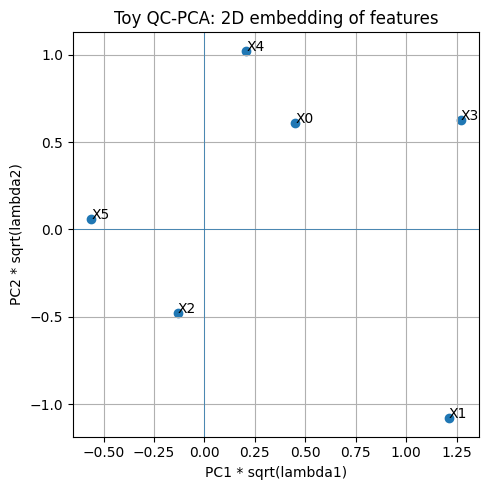

In [6]:
# Toy hybrid / quantum-inspired QC-PCA demo
# Bisa dijalankan langsung di Google Colab

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

def rand_pure_state(dim=2):
    """Random pure state |psi><psi| di C^dim."""
    v = (np.random.randn(dim) + 1j*np.random.randn(dim))
    v = v / la.norm(v)
    rho = np.outer(v, np.conjugate(v))
    return rho, v

def random_hermitian(n):
    """Random Hermitian matrix n x n."""
    A = np.random.randn(n, n) + 1j*np.random.randn(n, n)
    H = (A + A.conj().T) / 2
    return H

def partial_trace_rho_left(mat, dimA=2, dimB=2):
    """
    Tr_A[mat], dengan mat berukuran (dimA*dimB, dimA*dimB),
    dikembalikan matriks (dimB, dimB).
    """
    mat = mat.reshape((dimA, dimB, dimA, dimB))
    # trace over A indices (0 dan 2)
    res = np.einsum('i j i k -> j k', mat)
    return res

# --------- Parameter main toy ----------
d = 6      # jumlah fitur
dim = 2    # dimensi qubit per fitur (2 = qubit)

# 1) Buat embedding kuantum random untuk setiap fitur
rhos = []
kets = []
for i in range(d):
    rho, ket = rand_pure_state(dim)
    rhos.append(rho)
    kets.append(ket)

# 2) Bangun random Hermitian "process matrices" W_ij (4x4) untuk tiap pasangan
W = {}
for i in range(d):
    for j in range(d):
        W[(i, j)] = random_hermitian(dim * dim)

# 3) Hitung operator kausal C_{i->j} & H_ij
H_ops = [[None] * d for _ in range(d)]
for i in range(d):
    for j in range(d):
        rho_i = rhos[i]
        rho_j = rhos[j]

        # C_{i->j} = Tr_i[ W_{ij} (rho_i \otimes I_j) ]
        Ij = np.eye(dim)
        kron_ij = np.kron(rho_i, Ij)
        mat_ij = W[(i, j)] @ kron_ij
        C_i_j = partial_trace_rho_left(mat_ij, dimA=dim, dimB=dim)

        # C_{j->i}
        Ii = np.eye(dim)
        kron_ji = np.kron(rho_j, Ii)
        mat_ji = W[(j, i)] @ kron_ji
        C_j_i = partial_trace_rho_left(mat_ji, dimA=dim, dimB=dim)

        # H_ij = 0.5 * (C_{i->j} + C_{j->i}^\dagger), lalu dipaksa Hermitian numerik
        H = 0.5 * (C_i_j + C_j_i.conj().T)
        H = 0.5 * (H + H.conj().T)
        H_ops[i][j] = H

# 4) Kontraksi jadi skalar: h_ij = Re(Tr[ H_ij * rho_j ])
QCM = np.zeros((d, d), dtype=float)
for i in range(d):
    for j in range(d):
        h = np.trace(H_ops[i][j] @ rhos[j])
        QCM[i, j] = np.real(h)

# Simetrisasi dan regularisasi agar PSD
QCM = 0.5 * (QCM + QCM.T)
eigvals = la.eigvalsh(QCM)
min_ev = np.min(eigvals)
if min_ev < 1e-8:
    QCM = QCM + (abs(min_ev) + 1e-8) * np.eye(d)

# 5) Tampilkan QCM sebagai tabel
cols = [f"X{idx}" for idx in range(d)]
df_qcm = pd.DataFrame(np.round(QCM, 6), columns=cols, index=cols)
print("=== Toy QCM (scalar contraction) ===")
print(df_qcm)
print()

# 6) Eigen-decomposition (QC-PCA surrogate)
vals, vecs = la.eigh(QCM)   # ascending
idx = np.argsort(vals)[::-1]
vals = vals[idx]
vecs = vecs[:, idx]

print("Top eigenvalues:", np.round(vals[:min(5, len(vals))], 6))
print()

# 7) Scree plot eigenvalues
plt.figure(figsize=(6, 3))
plt.plot(np.arange(1, d + 1), vals, marker='o')
plt.title("Scree plot (Eigenvalues of Toy QCM)")
plt.xlabel("Component index (sorted)")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8) 2D embedding fitur pakai dua eigenvector teratas
r = 2
U_r = vecs[:, :r]
Lambda_r = vals[:r]
coords = U_r * np.sqrt(Lambda_r[np.newaxis, :])  # d x r

df_coords = pd.DataFrame(
    np.round(coords, 6),
    columns=[f"PC{k+1}" for k in range(r)],
    index=[f"X{idx}" for idx in range(d)],
)
print("=== Feature coordinates in 2D QC-PCA surrogate ===")
print(df_coords)
print()

plt.figure(figsize=(5, 5))
plt.scatter(coords[:, 0], coords[:, 1])
for i, txt in enumerate(df_coords.index):
    plt.annotate(txt, (coords[i, 0], coords[i, 1]))
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.title("Toy QC-PCA: 2D embedding of features")
plt.xlabel("PC1 * sqrt(lambda1)")
plt.ylabel("PC2 * sqrt(lambda2)")
plt.grid(True)
plt.tight_layout()
plt.show()
